# Task 3:  Build a model on Loan stats data

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import *
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector

In [2]:
data = spark.read.format("com.databricks.spark.csv")\
    .option("header","true")\
    .option("inferSchema","true")\
    .load("hdfs://localhost:8020/user/master/LoanStats3a.csv")

In [3]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

In [12]:
data.createOrReplaceTempView("data")

In [13]:
selectedColumn = data.select("int_rate", "loan_amnt", "term", "grade", "sub_grade", "emp_length", "verification_status", 
                   "home_ownership", "annual_inc", "purpose", "addr_state", "open_acc" )

In [15]:
A = selectedColumn.withColumn('int_rate', regexp_replace('int_rate', '%', ''))
loanTable = A.select(A.int_rate.cast("float"), "loan_amnt", "term", "grade", "sub_grade", "emp_length", "verification_status", 
                   "home_ownership", "annual_inc", "purpose", "addr_state", "open_acc" )
loanTable.show(5)

+--------+---------+----------+-----+---------+----------+-------------------+--------------+----------+--------------+----------+--------+
|int_rate|loan_amnt|      term|grade|sub_grade|emp_length|verification_status|home_ownership|annual_inc|       purpose|addr_state|open_acc|
+--------+---------+----------+-----+---------+----------+-------------------+--------------+----------+--------------+----------+--------+
|   10.65|     5000| 36 months|    B|       B2| 10+ years|           Verified|          RENT|   24000.0|   credit_card|        AZ|       3|
|   15.27|     2500| 60 months|    C|       C4|  < 1 year|    Source Verified|          RENT|   30000.0|           car|        GA|       3|
|   15.96|     2400| 36 months|    C|       C5| 10+ years|       Not Verified|          RENT|   12252.0|small_business|        IL|       2|
|   13.49|    10000| 36 months|    C|       C1| 10+ years|    Source Verified|          RENT|   49200.0|         other|        CA|      10|
|   12.69|     3000|

In [17]:
loanpd = loanTable.toPandas()

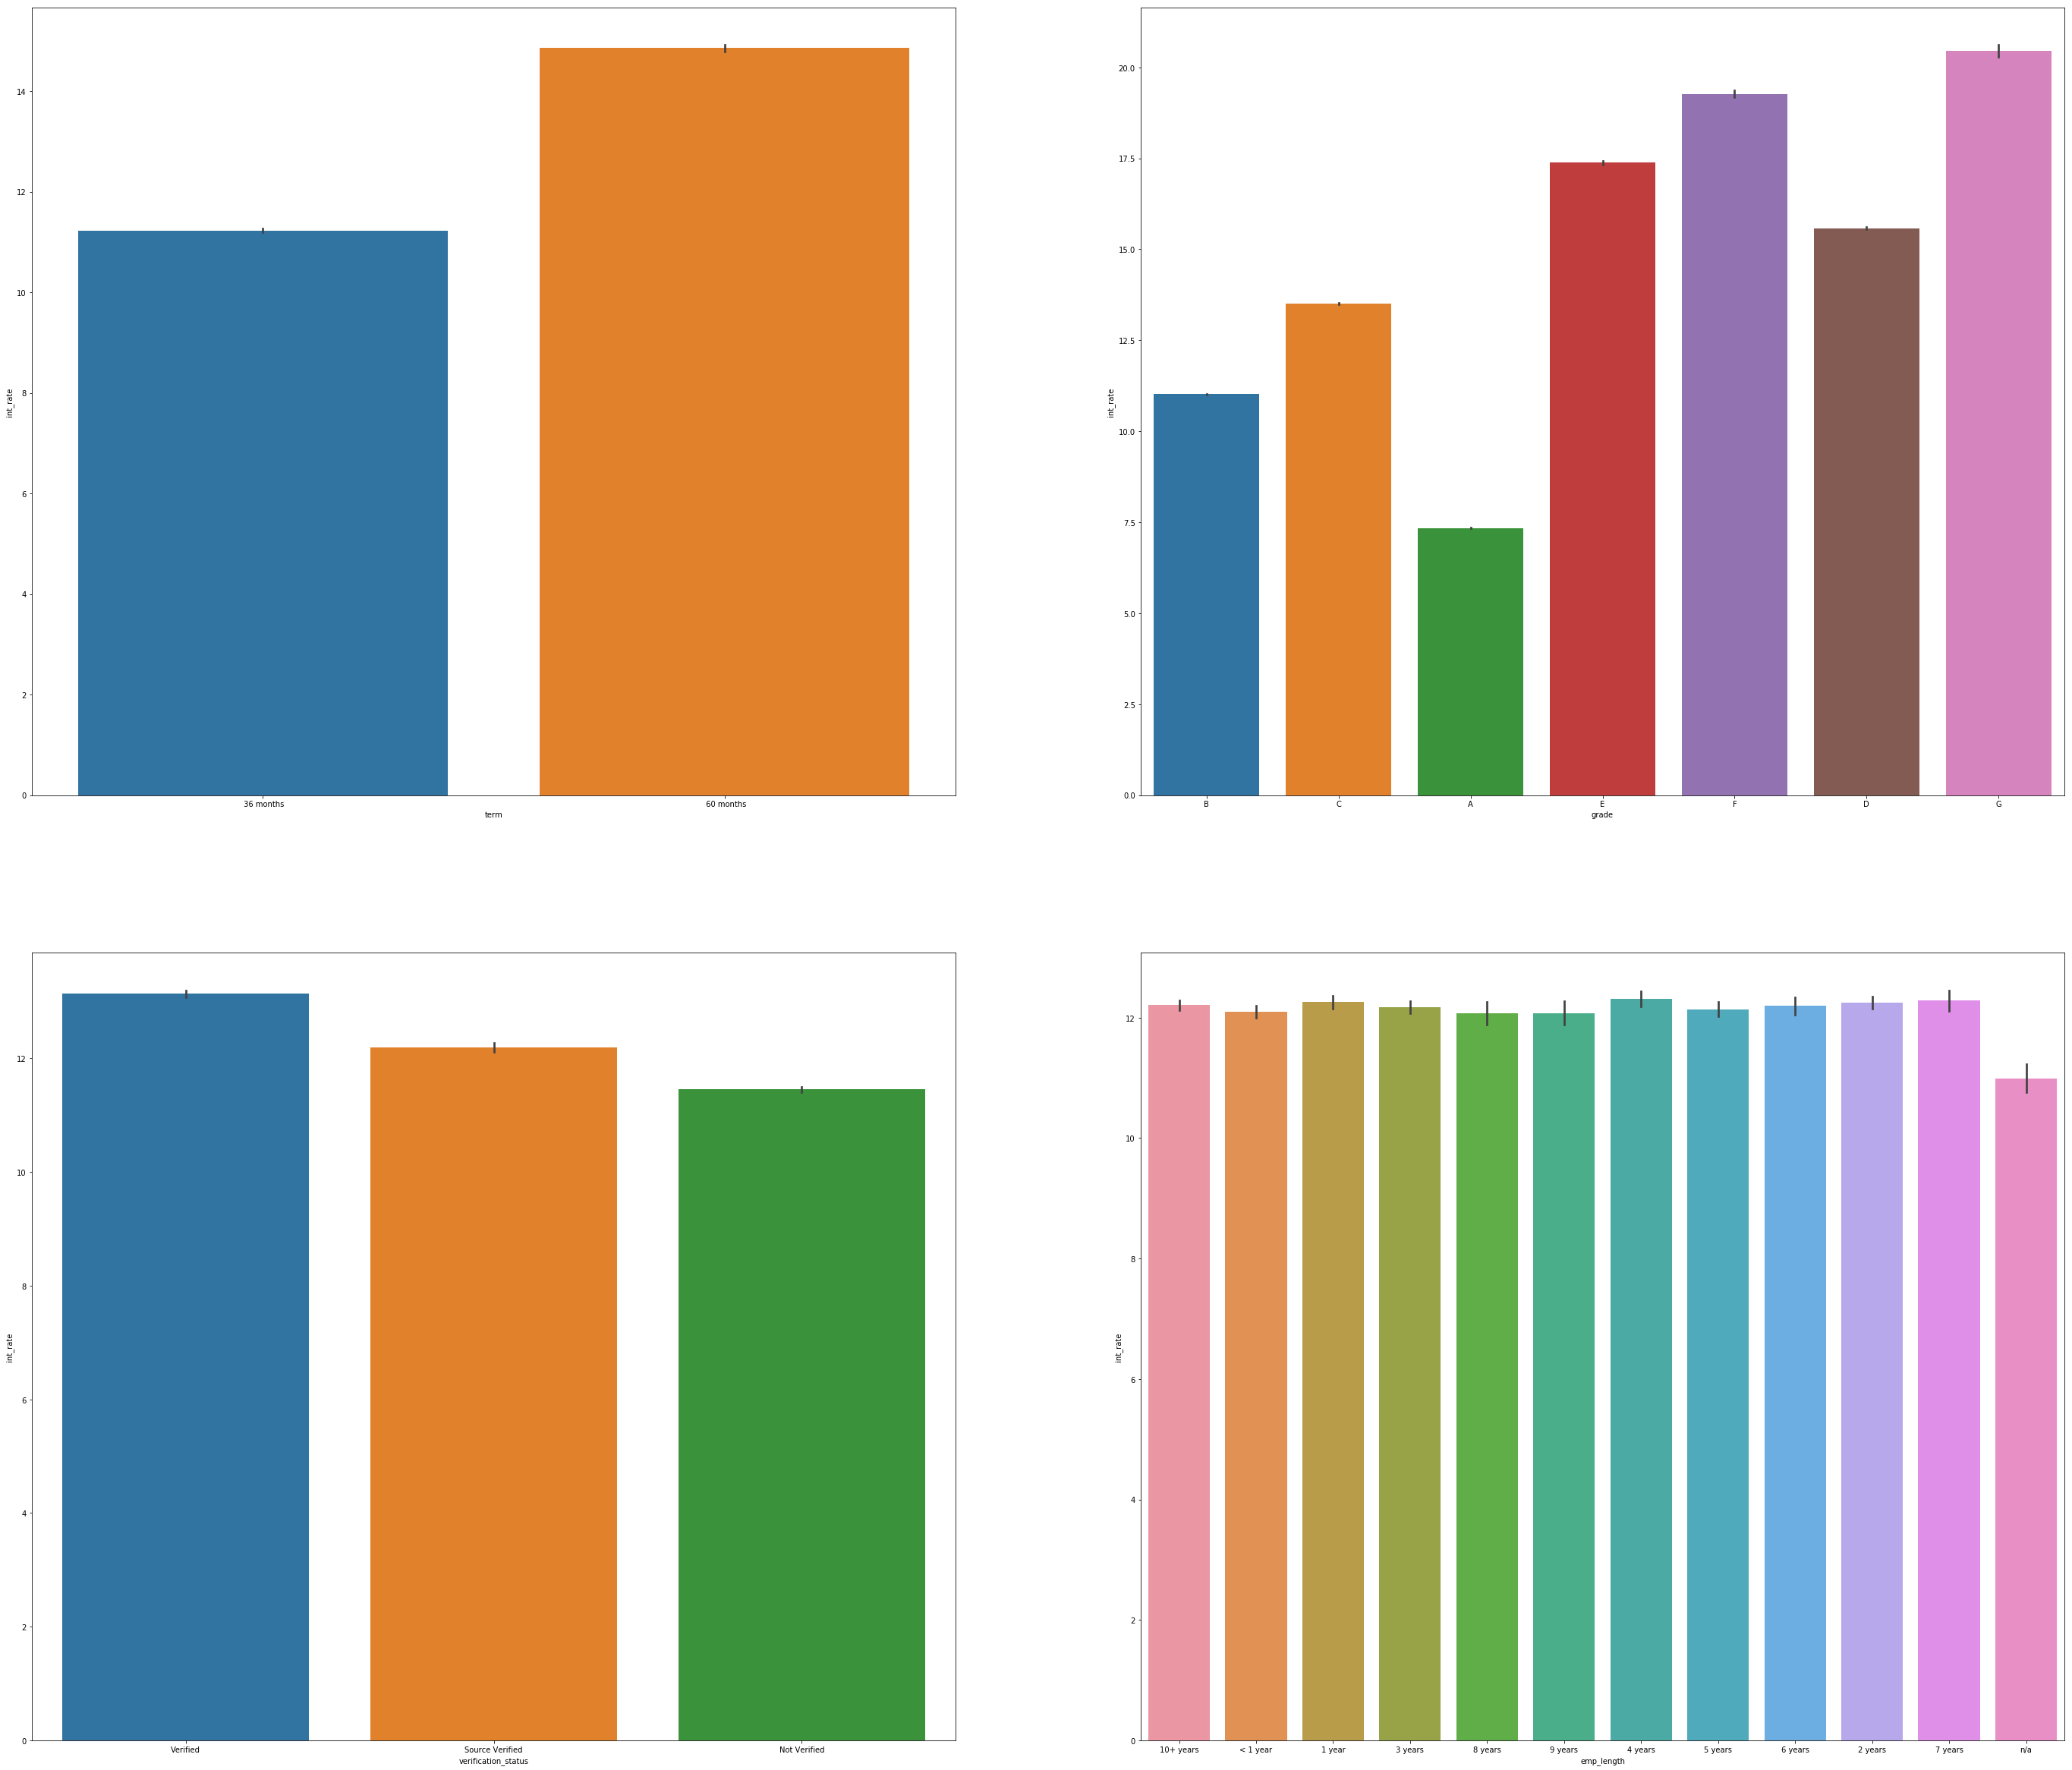

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(48, 42)
sns.barplot(data=loanpd, y="int_rate", x="term",orient="v",ax=axes[0][0])
sns.barplot(data=loanpd, y="int_rate", x="grade",orient="v",ax=axes[0][1])
sns.barplot(data=loanpd, y="int_rate", x="verification_status", orient="v",ax=axes[1][0])
sns.barplot(data=loanpd, y="int_rate", x="emp_length",orient="v",ax=axes[1][1])

In [21]:
loanTable.groupBy('term').count().sort("term", reverse=False).toPandas()

,term,count
0,None,1
1,36 months,31534
2,60 months,11001


In [22]:
loanTable.groupBy('purpose').count().sort("purpose", reverse=False).toPandas().head()

,purpose,count
0,None,1
1,After graduating from college,1
2,(Citi Bank) which they owned up to and admit...,1
3,"Hilal Khalil Homaidan""",1
4,I have requested this loan because of the hi...,1


In [23]:
loanTable.describe().toPandas()

,summary,int_rate,loan_amnt,term,grade,sub_grade,emp_length,verification_status,home_ownership,annual_inc,purpose,addr_state,open_acc
0,count,42535,42535,42535,42535,42535,42535,42535,42535,42531,42535,42535,42426
1,mean,12.16501557592417,11089.72258140355,None,None,None,None,None,None,69136.55642025817,384.0,0.0,9.341769012753897
2,stddev,3.7079355312171716,7410.938390546613,None,None,None,None,None,None,64096.34971887434,543.0580079512685,NaN,4.575322218466711
3,min,5.42,500,36 months,A,A1,1 year,Not Verified,MORTGAGE,1896.0,After graduating from college,American women use 12 personal care products ...,"Carlos"""
4,max,24.59,35000,60 months,G,G5,n/a,Verified,RENT,6000000.0,wedding,wedding,home_improvement


In [25]:
print("Total records in loan Table")
loanTable.count()

Total records in loan Table


42536

In [27]:
print("Total records in loan Table (removed missing values)")
loanTable1 = loanTable.dropna()
loanTable1.count()

Total records in loan Table (removed missing values)


42426

### Selected features to build model
|-- int_rate: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- purpose: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- open_acc: string (nullable = true)

In [59]:
loanTable1.show()

+--------+---------+----------+-----+---------+----------+-------------------+--------------+----------+------------------+----------+--------+
|int_rate|loan_amnt|      term|grade|sub_grade|emp_length|verification_status|home_ownership|annual_inc|           purpose|addr_state|open_acc|
+--------+---------+----------+-----+---------+----------+-------------------+--------------+----------+------------------+----------+--------+
|   10.65|     5000| 36 months|    B|       B2| 10+ years|           Verified|          RENT|   24000.0|       credit_card|        AZ|       3|
|   15.27|     2500| 60 months|    C|       C4|  < 1 year|    Source Verified|          RENT|   30000.0|               car|        GA|       3|
|   15.96|     2400| 36 months|    C|       C5| 10+ years|       Not Verified|          RENT|   12252.0|    small_business|        IL|       2|
|   13.49|    10000| 36 months|    C|       C1| 10+ years|    Source Verified|          RENT|   49200.0|             other|        CA|  

In [29]:
#transformation of categorical variables
    
termIndexer = StringIndexer(inputCol="term", outputCol = "termIndex")
gradeIndexer = StringIndexer(inputCol="grade", outputCol = "gradeIndex")
sub_gradeIndexer = StringIndexer(inputCol="sub_grade", outputCol = "sub_gradeIndex")

emp_lengthIndexer = StringIndexer(inputCol="emp_length", outputCol = "emp_lengthIndex")
verification_statusIndexer = StringIndexer(inputCol="verification_status", outputCol = "verification_statusIndex")
home_ownershipIndexer = StringIndexer(inputCol="home_ownership", outputCol = "home_ownershipIndex")

purposeIndexer = StringIndexer(inputCol="purpose", outputCol = "purposeIndex")
addr_stateIndexer = StringIndexer(inputCol="addr_state", outputCol = "addr_stateIndex")
open_accIndexer = StringIndexer(inputCol="open_acc", outputCol = "open_accIndex")

In [30]:
#Build model
modelterm = termIndexer.fit(loanTable1)
modelgrade = gradeIndexer.fit(loanTable1)
modelsub_grade = sub_gradeIndexer.fit(loanTable1)

modelemp_length = emp_lengthIndexer.fit(loanTable1)
modelverification_status = verification_statusIndexer.fit(loanTable1)
modelhome_ownership = home_ownershipIndexer.fit(loanTable1)

modelpurpose = purposeIndexer.fit(loanTable1)
modeladdr_state = addr_stateIndexer.fit(loanTable1)
modelopen_acc = open_accIndexer.fit(loanTable1)

In [ ]:
#run the model
indexedterm = modelterm.transform(loanTable1)
indexedgrade = modelgrade.transform(loanTable1)
indexedsub_grade = modelsub_grade.transform(loanTable1)

indexedemp_length = modelemp_length.transform(loanTable1)
indexedverification_status = modelverification_status.transform(loanTable1)
indexedhome_ownership = modelhome_ownership.transform(loanTable1)

indexedpurpose = modelpurpose.transform(loanTable1)
indexedaddr_state = modeladdr_state.transform(loanTable1)
indexedopen_acc = modelopen_acc.transform(loanTable1)

In [31]:
# selecting categorical valiables
col = loanTable1.select("term", "grade", "sub_grade", "emp_length", "verification_status", 
                   "home_ownership", "purpose", "addr_state", "open_acc")

In [32]:
indexer = [StringIndexer(inputCol=column, outputCol = column + "_Index").fit(loanTable1) for column in list(set(col.columns))]


In [34]:
pipeline = Pipeline(stages=indexer)
loanTable2 = pipeline.fit(loanTable1).transform(loanTable1)

In [35]:
loanTable2.show(5)

+--------+---------+----------+-----+---------+----------+-------------------+--------------+----------+--------------+----------+--------+-------------------------+----------+--------------+-----------+---------------+-------------+----------------+--------------------+----------------+
|int_rate|loan_amnt|      term|grade|sub_grade|emp_length|verification_status|home_ownership|annual_inc|       purpose|addr_state|open_acc|verification_status_Index|term_Index|open_acc_Index|grade_Index|sub_grade_Index|purpose_Index|emp_length_Index|home_ownership_Index|addr_state_Index|
+--------+---------+----------+-----+---------+----------+-------------------+--------------+----------+--------------+----------+--------+-------------------------+----------+--------------+-----------+---------------+-------------+----------------+--------------------+----------------+
|   10.65|     5000| 36 months|    B|       B2| 10+ years|           Verified|          RENT|   24000.0|   credit_card|        AZ|   

In [41]:
# Define the 'input_data'
input_data = loanTable2.rdd.map(lambda x: (x[0], DenseVector(x[12:21])))
input_data

PythonRDD[232] at RDD at PythonRDD.scala:48

In [42]:
# Create a dataframe
input_data1 = spark.createDataFrame(input_data,["label","features"])

In [43]:
# Showing first 5 rows
input_data1.show(5, truncate = False)

+------------------+---------------------------------------+
|label             |features                               |
+------------------+---------------------------------------+
|10.649999618530273|[1.0,0.0,10.0,0.0,7.0,1.0,0.0,0.0,12.0]|
|15.270000457763672|[2.0,1.0,10.0,2.0,13.0,6.0,1.0,0.0,7.0]|
|15.960000038146973|[0.0,0.0,15.0,2.0,15.0,5.0,0.0,0.0,5.0]|
|13.489999771118164|[2.0,0.0,4.0,2.0,5.0,2.0,0.0,0.0,0.0]  |
|12.6899995803833  |[2.0,1.0,12.0,0.0,2.0,2.0,5.0,0.0,24.0]|
+------------------+---------------------------------------+
only showing top 5 rows



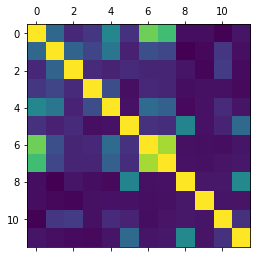

In [44]:
plt.matshow(loanTable2.toPandas().corr())

# split data into training & testing

In [45]:
train_data, test_data = input_data1.randomSplit([.7,.3], seed= 100)

In [46]:
print("train data count: " + str(train_data.count()))
print("test data count: " + str(test_data.count()))

train data count: 29764
test data count: 12662


## Build Linear Regression Model

In [47]:
# Import 'LinearRegression'
from pyspark.ml.regression import LinearRegression

In [48]:
# Initialize 'lr'
lr = LinearRegression(labelCol="label", maxIter=100,regParam=0.3, elasticNetParam=0.8)

In [49]:
# Fit the data to the model
linearModel = lr.fit(train_data)

In [50]:
# Generate predictions
predicted = linearModel.transform(test_data)

In [51]:
# Extract the predictions and the "known" correct labels
predictions = predicted.select("prediction").rdd.map(lambda x:x[0])
labels = predicted.select("label").rdd.map(lambda x: x[0])

In [52]:
predictionAndLabel = predictions.zip(labels).collect()

In [53]:
predictionAndLabel[:5]

[(11.069018945691129, 5.420000076293945),
 (11.069018945691129, 5.420000076293945),
 (11.069018945691129, 5.420000076293945),
 (11.069018945691129, 5.420000076293945),
 (11.069018945691129, 5.420000076293945)]

In [54]:
# Coefficients of the model
linearModel.coefficients

DenseVector([0.0, 1.399, 0.0, 1.4726, 0.0287, 0.0, 0.0, 0.0, 0.0])

In [55]:
# Intercept for the model
linearModel.intercept

9.1370892167239

In [56]:
# RMSE
linearModel.summary.rootMeanSquaredError

2.294231333902039

In [57]:
# Get the R2
linearModel.summary.r2

0.6165797387530388

# Task 3 Finished